In [41]:
import pandas as pd
import sqlite3
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt

In [28]:
!cp ../Scrapers/nfl.db .
db_path = 'nfl.db'  # Update this path if needed

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Get all table names
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()

# Download each table to a CSV file
for table in tables:
    table_name = table[0]
    # Read the table into a pandas DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    # Save the DataFrame to a CSV file
    csv_file_name = f"{table_name}.csv"
    df.to_csv(csv_file_name, index=False)
    print(f"Downloaded {table_name} to {csv_file_name}")

# Close the connection
conn.close()

Downloaded Teams to Teams.csv
Downloaded PlayerStats to PlayerStats.csv
Downloaded Rosters to Rosters.csv
Downloaded Games to Games.csv


In [29]:
# Create Defense Strength

player_stats_df = pd.read_csv('PlayerStats.csv', low_memory=False)

# Step 2: Calculate Defense Strength for Each Season
# Group by season and team (both home and away) to calculate the total touchdowns and yards allowed
home_stats = player_stats_df.groupby(['season', 'home_team']).agg(
    rushing_tds_sum=('rushing_tds', 'sum'),
    passing_tds_sum=('passing_tds', 'sum'),
    receiving_tds_sum=('receiving_tds', 'sum'),
    rushing_yards_sum=('rushing_yards', 'sum'),
    receiving_yards_sum=('receiving_yards', 'sum')
).reset_index().rename(columns={'home_team': 'team_name'})

away_stats = player_stats_df.groupby(['season', 'away_team']).agg(
    rushing_tds_sum=('rushing_tds', 'sum'),
    passing_tds_sum=('passing_tds', 'sum'),
    receiving_tds_sum=('receiving_tds', 'sum'),
    rushing_yards_sum=('rushing_yards', 'sum'),
    receiving_yards_sum=('receiving_yards', 'sum')
).reset_index().rename(columns={'away_team': 'team_name'})

# Combine home and away stats
team_defense_stats = pd.concat([home_stats, away_stats])

# Aggregate the data to sum up home and away stats per team per season
team_defense_stats = team_defense_stats.groupby(['season', 'team_name']).sum().reset_index()

# Calculate total touchdowns allowed and total yards allowed
team_defense_stats['total_touchdowns_allowed'] = (
    team_defense_stats['rushing_tds_sum'] + 
    team_defense_stats['passing_tds_sum'] + 
    team_defense_stats['receiving_tds_sum']
)

team_defense_stats['total_yards_allowed'] = (
    team_defense_stats['rushing_yards_sum'] + 
    team_defense_stats['receiving_yards_sum']
)

# Drop intermediate columns to clean up
team_defense_stats.drop(columns=[
    'rushing_tds_sum', 'passing_tds_sum', 'receiving_tds_sum',
    'rushing_yards_sum', 'receiving_yards_sum'
], inplace=True)

# Step 3: Weight and Normalize Metrics for Each Season Separately
weights = {
    'total_touchdowns_allowed': 0.5,
    'total_yards_allowed': 0.5
}

# Apply the weights and calculate the composite defense strength for each season
team_defense_stats['composite_defense_strength'] = (
    weights['total_touchdowns_allowed'] * team_defense_stats['total_touchdowns_allowed'] +
    weights['total_yards_allowed'] * team_defense_stats['total_yards_allowed']
)

# Normalize and invert for each season separately
team_defense_stats['defense_strength'] = team_defense_stats.groupby('season')['composite_defense_strength'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)
team_defense_stats['defense_strength'] = 1 - team_defense_stats['defense_strength']

# Step 4: Duplicate the 2023 Scores for 2024
team_defense_stats_2024 = team_defense_stats[team_defense_stats['season'] == 2023].copy()
team_defense_stats_2024['season'] = 2024

# Combine the original and duplicated data
team_defense_stats = pd.concat([team_defense_stats, team_defense_stats_2024])

# Save all defense strengths to CSV
team_defense_stats.to_csv('defense_strength.csv', index=False)

# Step 5: Merge with PlayerStats DataFrame for Selected Seasons
defense_strength_df = pd.read_csv('defense_strength.csv')

# Create the 'opponent_team' column
player_stats_df['opponent_team'] = player_stats_df['away_team'].where(
    player_stats_df['player_current_team'] == player_stats_df['home_team'], 
    player_stats_df['home_team']
)

# Merge the defense strengths for the selected seasons into PlayerStats
player_stats_df = pd.merge(
    player_stats_df,
    defense_strength_df,
    how='left',
    left_on=['opponent_team', 'season'],
    right_on=['team_name', 'season']
)

# Rename the defense strength column for clarity
player_stats_df.rename(columns={'defense_strength': 'opponent_defense_strength'}, inplace=True)

# Drop the extra 'team_name' column
player_stats_df.drop(columns=['team_name'], inplace=True)

# Save the updated DataFrame back to a CSV file
player_stats_df.to_csv('PlayerStats.csv', index=False)

# Optionally, display the first few rows to verify
print(player_stats_df.head())

     player_display_name player_current_team         game_id  season  week  \
0  Abdul-Karim al-Jabbar                 IND  2000_01_IND_KC    2000     1   
1         Rabih Abdullah                  TB   2000_01_TB_NE    2000     1   
2         Rabih Abdullah                  TB  2000_12_TB_CHI    2000    12   
3         Rabih Abdullah                  TB  2000_14_DAL_TB    2000    14   
4         Rabih Abdullah                  TB  2000_15_TB_MIA    2000    15   

  position headshot_url  completions  attempts  passing_yards  ...  \
0       RB          NaN            0         0              0  ...   
1       RB          NaN            0         0              0  ...   
2       RB          NaN            0         0              0  ...   
3       RB          NaN            0         0              0  ...   
4       RB          NaN            0         0              0  ...   

   receiving_tds  receiving_fumbles  fantasy_points_ppr  home_team  away_team  \
0              0             

In [12]:
# Generate player current team and add empty rows to PlayerStats.csv

# Suppress the SettingWithCopyWarning in this cell
# pd.options.mode.chained_assignment = None  # default='warn'

db_path = 'nfl.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to select player names and current teams for the 2024 season
players_2024_query = """
SELECT full_name AS player_name, team AS current_team
FROM Rosters
WHERE season = 2024;
"""

# Execute the query and load the results into a DataFrame
players_2024_df = pd.read_sql_query(players_2024_query, conn)

# Close the database connection
conn.close()

# Specify the output CSV file path
output_csv_path = 'players_2024.csv'

# Save the DataFrame to a CSV file
players_2024_df.to_csv(output_csv_path, index=False)

# Notify that the file has been saved
print(f"CSV file saved to {output_csv_path}")

# Path to your SQLite database
db_path = 'nfl.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Load the players and their current teams for the 2024 season
players_2024_query = """
SELECT full_name AS player_name, team AS current_team
FROM Rosters
WHERE season = 2024;
"""
players_2024_df = pd.read_sql_query(players_2024_query, conn)

# Load the games for the 2024 season
games_2024_query = """
SELECT week, home_team, away_team
FROM Games
WHERE season = 2024;
"""
games_2024_df = pd.read_sql_query(games_2024_query, conn)

# Close the database connection
conn.close()

# Prepare the output DataFrame
output_df = pd.DataFrame()

# Loop over each player and find their opponents
for index, player in players_2024_df.iterrows():
    player_name = player['player_name']
    current_team = player['current_team']
    
    # Find games where the player's team is either the home or away team
    player_games = games_2024_df[(games_2024_df['home_team'] == current_team) | (games_2024_df['away_team'] == current_team)]
    
    # Determine the opponent team for each game
    player_games['opponent_team'] = player_games.apply(
        lambda row: row['away_team'] if row['home_team'] == current_team else row['home_team'], axis=1
    )
    
    # Add the player name and current team to the DataFrame
    player_games['player_name'] = player_name
    player_games['current_team'] = current_team
    
    # Select relevant columns
    player_games = player_games[['player_name', 'current_team', 'week', 'opponent_team']]
    
    # Append to the output DataFrame
    output_df = pd.concat([output_df, player_games], ignore_index=True)

# Save the output DataFrame to a CSV file
output_csv_path = 'players_2024_w_opponents.csv'
output_df.to_csv(output_csv_path, index=False)

# Notify that the file has been saved
print(f"CSV file saved to {output_csv_path}")

# Load the PlayerStats.csv file
player_stats_path = 'PlayerStats.csv'
player_stats_df = pd.read_csv(player_stats_path)

# Load the players_2024_w_opponents.csv file
players_opponents_path = 'players_2024_w_opponents.csv'
players_opponents_df = pd.read_csv(players_opponents_path)

# Prepare an empty list to collect new rows
new_rows_list = []

# Add rows to PlayerStats for each player's upcoming game with the opponent team filled
for index, row in players_opponents_df.iterrows():
    new_row = {col: '' for col in player_stats_df.columns}  # Initialize all cells as empty
    
    # Fill in player_display_name, player_current_team, opponent_team, and season
    new_row['player_display_name'] = row['player_name']
    new_row['player_current_team'] = row['current_team']
    new_row['week'] = row['week']
    new_row['opponent_team'] = row['opponent_team']
    new_row['season'] = '2024'  # Append '2024' to the season column  # <- This line was added
    
    new_rows_list.append(new_row)

# Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows_list)

# Combine the existing PlayerStats with the new rows
updated_player_stats_df = pd.concat([player_stats_df, new_rows_df], ignore_index=True)

# Save the updated DataFrame back to a CSV file
updated_player_stats_path = 'PlayerStats.csv'
updated_player_stats_df.to_csv(updated_player_stats_path, index=False)

# Notify that the file has been saved
print(f"CSV file saved to {updated_player_stats_path}")


CSV file saved to players_2024.csv


/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_7243/3117060447.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_games['opponent_team'] = player_games.apply(
/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_7243/3117060447.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_games['player_name'] = player_name
/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_7243/3117060447.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

CSV file saved to players_2024_w_opponents.csv
CSV file saved to PlayerStats.csv


In [30]:
import pandas as pd
import sqlite3

# Suppress the SettingWithCopyWarning in this cell
# pd.options.mode.chained_assignment = None  # default='warn'

# Path to your SQLite database
db_path = 'nfl.db'

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Step 1: Load the players, their current teams, and positions for the 2024 season
players_2024_query = """
SELECT full_name AS player_name, team AS current_team, position
FROM Rosters
WHERE season = 2024;
"""
players_2024_df = pd.read_sql_query(players_2024_query, conn)

# Step 2: Load the games for the 2024 season
games_2024_query = """
SELECT week, home_team, away_team
FROM Games
WHERE season = 2024;
"""
games_2024_df = pd.read_sql_query(games_2024_query, conn)

# Close the database connection
conn.close()

# Step 3: Prepare the output DataFrame
output_df = pd.DataFrame()

# Step 4: Loop over each player and find their opponents
for index, player in players_2024_df.iterrows():
    player_name = player['player_name']
    current_team = player['current_team']
    position = player['position']  # Get the player's position
    
    # Find games where the player's team is either the home or away team
    player_games = games_2024_df[(games_2024_df['home_team'] == current_team) | (games_2024_df['away_team'] == current_team)]
    
    # Determine the opponent team for each game
    player_games['opponent_team'] = player_games.apply(
        lambda row: row['away_team'] if row['home_team'] == current_team else row['home_team'], axis=1
    )
    
    # Add the player name, current team, and position to the DataFrame
    player_games['player_name'] = player_name
    player_games['current_team'] = current_team
    player_games['position'] = position  # Add the player's position to the DataFrame
    
    # Select relevant columns
    player_games = player_games[['player_name', 'current_team', 'position', 'week', 'opponent_team']]
    
    # Append to the output DataFrame
    output_df = pd.concat([output_df, player_games], ignore_index=True)

# Step 5: Save the output DataFrame to a CSV file
output_csv_path = 'players_2024_w_opponents.csv'
output_df.to_csv(output_csv_path, index=False)

# Notify that the file has been saved
print(f"CSV file saved to {output_csv_path}")

# Step 6: Load the PlayerStats.csv file
player_stats_path = 'PlayerStats.csv'
player_stats_df = pd.read_csv(player_stats_path)

# Step 7: Load the players_2024_w_opponents.csv file
players_opponents_path = 'players_2024_w_opponents.csv'
players_opponents_df = pd.read_csv(players_opponents_path)

# Step 8: Prepare an empty list to collect new rows
new_rows_list = []

# Step 9: Add rows to PlayerStats for each player's upcoming game with the opponent team and position filled
for index, row in players_opponents_df.iterrows():
    new_row = {col: '' for col in player_stats_df.columns}  # Initialize all cells as empty
    
    # Fill in player_display_name, player_current_team, opponent_team, position, and season
    new_row['player_display_name'] = row['player_name']
    new_row['player_current_team'] = row['current_team']
    new_row['position'] = row['position']  # Add the position to the new row
    new_row['week'] = row['week']
    new_row['opponent_team'] = row['opponent_team']
    new_row['season'] = '2024'  # Append '2024' to the season column
    
    new_rows_list.append(new_row)

# Step 10: Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows_list)

# Step 11: Combine the existing PlayerStats with the new rows
updated_player_stats_df = pd.concat([player_stats_df, new_rows_df], ignore_index=True)

# Step 12: Save the updated DataFrame back to a CSV file
updated_player_stats_path = 'PlayerStats.csv'
updated_player_stats_df.to_csv(updated_player_stats_path, index=False)

# Notify that the file has been saved
print(f"CSV file saved to {updated_player_stats_path}")


/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_7243/121001536.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_games['opponent_team'] = player_games.apply(
/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_7243/121001536.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_games['player_name'] = player_name
/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_7243/121001536.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

CSV file saved to players_2024_w_opponents.csv
CSV file saved to PlayerStats.csv


In [31]:
# Merge the 2024 opponent defense scores with PlayerStats.csv

player_stats_df = pd.read_csv('PlayerStats.csv', low_memory=False)

# Load the defense_strength.csv file
defense_strength_df = pd.read_csv('defense_strength.csv')

# Filter the defense_strength_df for the 2024 season and set the team_name as index for easier mapping
defense_strength_2024_df = defense_strength_df[defense_strength_df['season'] == 2024].set_index('team_name')

# Update the 'opponent_defense_strength' column in PlayerStats.csv for the 2024 season
player_stats_df.loc[player_stats_df['season'] == 2024, 'opponent_defense_strength'] = player_stats_df.loc[player_stats_df['season'] == 2024, 'opponent_team'].map(defense_strength_2024_df['defense_strength'])

# Save the updated DataFrame back to a CSV file
player_stats_df.to_csv('PlayerStats.csv', index=False)

# Optionally, display the first few rows to verify the update
print(player_stats_df[player_stats_df['season'] == 2024][['opponent_team', 'opponent_defense_strength']].head())


       opponent_team  opponent_defense_strength
122427            SF                   0.115053
122428           TEN                   0.782470
122429            NE                   0.967530
122430           DEN                   0.655593
122431           MIN                   0.619745


In [5]:
# import pandas as pd

# # Load the Games.csv file
# games_df = pd.read_csv('Games.csv')

# # Function to calculate team stats for a given role (home or away)
# def calculate_team_stats(df, team_col, score_col, opponent_score_col):
#     # Calculate average points scored by the team
#     avg_scored = df.groupby(['season', team_col])[score_col].mean().reset_index()
#     avg_scored = avg_scored.rename(columns={score_col: 'avg_points_scored'})
    
#     # Calculate average points allowed by the team
#     avg_allowed = df.groupby(['season', team_col])[opponent_score_col].mean().reset_index()
#     avg_allowed = avg_allowed.rename(columns={opponent_score_col: 'avg_points_allowed'})
    
#     # Merge the scored and allowed stats
#     team_stats = pd.merge(avg_scored, avg_allowed, left_on=['season', team_col], right_on=['season', team_col])
    
#     # Rename columns for clarity
#     team_stats = team_stats.rename(columns={team_col: 'team'})
    
#     return team_stats

# # Process home team statistics
# home_team_stats = calculate_team_stats(
#     games_df,
#     team_col='home_team',
#     score_col='home_score',
#     opponent_score_col='away_score'
# )

# # Process away team statistics
# away_team_stats = calculate_team_stats(
#     games_df,
#     team_col='away_team',
#     score_col='away_score',
#     opponent_score_col='home_score'
# )

# # Combine home and away stats
# combined_stats = pd.concat([home_team_stats, away_team_stats])

# # Aggregate combined stats to get the final average per team per season
# final_stats = combined_stats.groupby(['season', 'team']).agg({
#     'avg_points_scored': 'mean',
#     'avg_points_allowed': 'mean'
# }).reset_index()

# # Save to CSV
# final_stats.to_csv('team_stats.csv', index=False)

# print("team_stats.csv has been created successfully.")
# !open team_stats.csv

team_stats.csv has been created successfully.


In [56]:
# # Merge avg points allowed to PlayerStats.csv

# # Load PlayerStats.csv and team_stats.csv
# player_stats_df = pd.read_csv('PlayerStats.csv')
# team_stats_df = pd.read_csv('team_stats.csv')

# # Ensure team_stats_df has the correct column names
# team_stats_df = team_stats_df.rename(columns={'team': 'player_current_team'})

# # Prepare the team_stats_df for merging by renaming columns
# team_stats_df = team_stats_df.rename(columns={
#     'player_current_team': 'team',
#     'avg_points_scored': 'team_avg_points_scored',
#     'avg_points_allowed': 'opponent_avg_points_allowed'
# })

# # Merge PlayerStats with team_stats on 'player_current_team' and 'season'
# merged_df = pd.merge(player_stats_df, team_stats_df[['team', 'season', 'opponent_avg_points_allowed']], 
#                      left_on=['opponent_team', 'season'], 
#                      right_on=['team', 'season'], 
#                      how='left')

# # Drop the redundant 'team' column
# merged_df = merged_df.drop(columns=['team'])

# # Rename 'opponent_avg_points_allowed' for clarity
# merged_df = merged_df.rename(columns={'opponent_avg_points_allowed': 'opponent_avg_points_allowed'})

# # Save the updated DataFrame to a new CSV file
# merged_df.to_csv('PlayerStats.csv', index=False)

# print("PlayerStats.csv has been created successfully.")

/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/843752255.py:4: DtypeWarning: Columns (2,5,6,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  player_stats_df = pd.read_csv('PlayerStats.csv')


PlayerStats.csv has been created successfully.


In [58]:
# # Merge avg points scored to PlayerStats.csv

# # Load PlayerStats.csv and team_stats.csv
# player_stats_df = pd.read_csv('PlayerStats.csv')
# team_stats_df = pd.read_csv('team_stats.csv')

# # Merge PlayerStats with team_stats on 'player_current_team' and 'season'
# # Rename columns in team_stats_df to match the merge keys in player_stats_df
# team_stats_df = team_stats_df.rename(columns={'team': 'player_current_team'})

# # Merge the data
# merged_df = pd.merge(player_stats_df, team_stats_df[['player_current_team', 'season', 'avg_points_scored']], 
#                      on=['player_current_team', 'season'], 
#                      how='left')

# # Rename 'avg_points_scored' to 'team_avg_points_scored'
# merged_df = merged_df.rename(columns={'avg_points_scored': 'team_avg_points_scored'})

# # Save the updated DataFrame to a new CSV file
# merged_df.to_csv('PlayerStats.csv', index=False)

# print("PlayerStats.csv has been created successfully.")

/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/2136652183.py:4: DtypeWarning: Columns (2,5,6,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  player_stats_df = pd.read_csv('PlayerStats.csv')


PlayerStats.csv has been created successfully.


In [32]:
# create master_model.csv using all new and wanted features/data

player_stats_df = pd.read_csv('PlayerStats.csv', low_memory=False)

# Define the columns to extract with 'opponent_team' after 'player_current_team'
columns_to_extract = [
    'player_display_name', 'player_current_team', 'opponent_team', 'game_id', 'season', 'week',
    'position', 'rushing_tds', 'receiving_tds', 'receptions', 'targets', 'receiving_yards', 'home_team', 'away_team',
    'opponent_defense_strength',
]

# Extract the desired columns
filtered_df = player_stats_df[columns_to_extract]

# Save the filtered DataFrame to master_model.csv
filtered_df.to_csv('master_model.csv', index=False)

print("master_model.csv has been created successfully.")
!open master_model.csv

master_model.csv has been created successfully.


---

# Probability of WR Scoring a Touchdown in an Upcoming Game

### Start w/ Features We Don't Need To Infer for Upcoming Game

- Opponent Avg Points Allowed
- Opponent Avg Receiving Touchdowns Allowed
- Opponent Avg Rushing Touchdowns Allowed
- Opponent Avg Receiving+Rushing Yards Allowed
- Player Avg Touchdown Scored per Game
- Player's Team Avg Points Scored per Game
- League WR Avg Touchdown Scored per Game
- Weather?
- Opponent Defense ELO?
- QB Rating?



***maybe go back to this***
- Opponent Defense Strength Score
    - points allowed
    - yards allowed
    - interceptions
    - sacks

# Model 1

AUC-ROC Score: 0.7788685853648712
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      7259
           1       0.62      0.26      0.36      2011

    accuracy                           0.80      9270
   macro avg       0.72      0.61      0.62      9270
weighted avg       0.78      0.80      0.77      9270



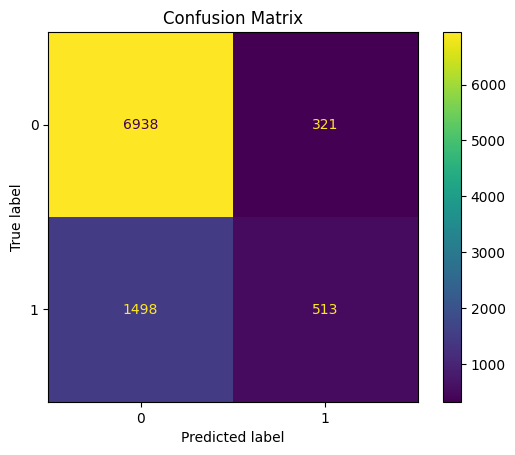

Log Loss: 0.43957921223947566


In [45]:
# Create model

file_path = 'master_model.csv'  # Replace with your actual file path
data = pd.read_csv(file_path, low_memory=False)

# Step 2: Save the 2024 season data to a new file before filtering it out
data = data[data['position'] == 'WR']  # Keep only WRs
upcoming_games_data = data[data['season'] == 2024].copy()
upcoming_games_data.to_csv('upcoming_games.csv', index=False)

# Step 3: Data Cleaning - Drop rows with missing 'season' and 'position' as they are critical
data_cleaned = data.dropna(subset=['season', 'position'])
data_cleaned = data_cleaned[data_cleaned['season'] < 2024]

# Step 3.5: Remove rows where all relevant stats are zeros (indicating the player likely didn't play)
data_cleaned = data_cleaned[
    (data_cleaned['receptions'] > 0) |
    (data_cleaned['targets'] > 0) |
    (data_cleaned['receiving_yards'] > 0) |
    (data_cleaned['rushing_tds'] > 0) |
    (data_cleaned['receiving_tds'] > 0)
]

# Convert columns to appropriate data types
data_cleaned['season'] = data_cleaned['season'].astype(int)
data_cleaned['week'] = data_cleaned['week'].astype(int)
data_cleaned['rushing_tds'] = data_cleaned['rushing_tds'].astype(int)
data_cleaned['receiving_tds'] = data_cleaned['receiving_tds'].astype(int)
data_cleaned['receptions'] = data_cleaned['receptions'].astype(int)
data_cleaned['targets'] = data_cleaned['targets'].astype(int)
data_cleaned['receiving_yards'] = data_cleaned['receiving_yards'].astype(int)
data_cleaned['opponent_defense_strength'] = data_cleaned['opponent_defense_strength'].astype(float)

# Step 4: Selecting WR players and creating a binary target variable for whether they scored a touchdown
data_wr = data_cleaned.loc[data_cleaned['position'] == 'WR'].copy()
data_wr.loc[:, 'total_tds'] = data_wr['rushing_tds'] + data_wr['receiving_tds']
data_wr.loc[:, 'scored_touchdown'] = np.where(data_wr['total_tds'] > 0, 1, 0)

# Step 5: Features and target
features = ['receptions', 'targets', 'receiving_yards', 'opponent_defense_strength']
target = 'scored_touchdown'

# Step 6: Train-test split
train_data, test_data = train_test_split(data_wr, test_size=0.2, random_state=42)

# Step 7: Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_data[features], train_data[target])

# Step 8: Evaluate the model
predictions = model.predict_proba(test_data[features])[:, 1]
roc_auc = roc_auc_score(test_data[target], predictions)
classification_rep = classification_report(test_data[target], model.predict(test_data[features]))

print(f'AUC-ROC Score: {roc_auc}')
print('Classification Report:')
print(classification_rep)

cm = confusion_matrix(test_data[target], model.predict(test_data[features]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

logloss = log_loss(test_data[target], predictions)
print(f"Log Loss: {logloss}")

In [ ]:
# Predict upcoming games

# Step 9: Calculate the average receptions, targets, and receiving yards for each player over the last two seasons (2022 and 2023)
# Filter for the last two seasons (2022 and 2023)
recent_seasons_data = data[(data['season'] == 2022) | (data['season'] == 2023)]

# Calculate the average receptions, targets, and receiving yards per player
player_averages = recent_seasons_data.groupby('player_display_name').agg({
    'receptions': 'mean',
    'targets': 'mean',
    'receiving_yards': 'mean'
}).reset_index()

# Rename columns to indicate that these are averages
player_averages.rename(columns={
    'receptions': 'avg_receptions',
    'targets': 'avg_targets',
    'receiving_yards': 'avg_receiving_yards'
}, inplace=True)

# Step 10: Merge the 2024 season data with the player averages
upcoming_games_data = upcoming_games_data.merge(player_averages, on='player_display_name', how='left')

# Step 11: Prepare the DataFrame for prediction
# We will use the averages for the 2024 rows and keep the existing opponent_defense_strength
upcoming_games_data['receptions'] = upcoming_games_data['avg_receptions']
upcoming_games_data['targets'] = upcoming_games_data['avg_targets']
upcoming_games_data['receiving_yards'] = upcoming_games_data['avg_receiving_yards']

# Check for NaN values and fill them with appropriate placeholders
upcoming_games_data[['receptions', 'targets', 'receiving_yards']] = upcoming_games_data[['receptions', 'targets', 'receiving_yards']].fillna(0)

# Keep only the necessary columns for prediction
predictive_features = upcoming_games_data[['receptions', 'targets', 'receiving_yards', 'opponent_defense_strength']]

# Step 12: Predict the probabilities of scoring a touchdown
upcoming_games_data['probability_of_td'] = model.predict_proba(predictive_features)[:, 1]

# Step 13: Save the predictions to a CSV or display them
upcoming_games_data.to_csv('upcoming_games_predictions.csv', index=False)
print(upcoming_games_data[['player_display_name', 'receptions', 'targets', 'receiving_yards', 'opponent_defense_strength', 'probability_of_td']])

In [38]:
# Convert output to american odds

output_csv_path = 'upcoming_games_predictions.csv'
output_df = pd.read_csv(output_csv_path)

# Define the function to convert probabilities to American odds
def probability_to_american_odds(prob):
    epsilon = 1e-10
    prob = max(min(prob, 1 - epsilon), epsilon)
    if prob > 0.5:
        return -100 * (prob / (1 - prob))
    else:
        return 100 * ((1 - prob) / prob)

# Apply the function to the probability_of_td column and create a new american_odds column
output_df['american_odds'] = output_df['probability_of_td'].apply(probability_to_american_odds)

# Filter the DataFrame to include only Week 1 games
week_1_df = output_df[output_df['week'] == 1]

# Save the Week 1 games with American odds to a new CSV file
week_1_df.to_csv('week_1_games_with_american_odds.csv', index=False)

# Print the first few rows to verify
print(week_1_df[['player_display_name', 'week', 'probability_of_td', 'american_odds']].head())


   player_display_name  week  probability_of_td  american_odds
0         Adam Thielen     1           0.228354     337.917243
17        Keenan Allen     1           0.425909     134.792134
34        Robert Woods     1           0.141706     605.687581
51     DeAndre Hopkins     1           0.308365     224.290942
68   Odell Beckham Jr.     1           0.072822    1273.216798


Random Forest AUC-ROC Score: 0.7311562477458151
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      7259
           1       0.44      0.31      0.37      2011

    accuracy                           0.76      9270
   macro avg       0.63      0.60      0.61      9270
weighted avg       0.74      0.76      0.75      9270



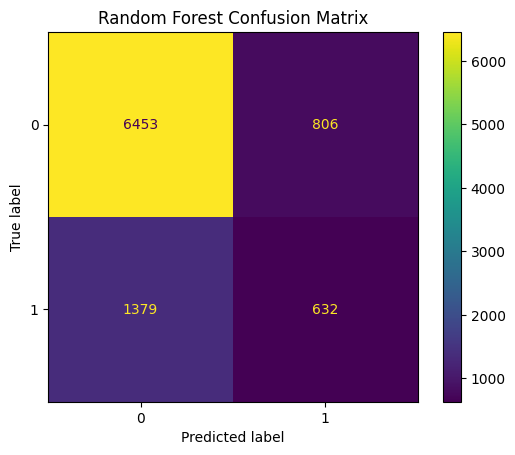

Random Forest Log Loss: 0.7576309511495237


In [46]:
# Random Forest Classifier:

from sklearn.ensemble import RandomForestClassifier

# Step 7: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(train_data[features], train_data[target])

# Step 8: Evaluate the Random Forest model
rf_predictions = rf_model.predict_proba(test_data[features])[:, 1]
rf_roc_auc = roc_auc_score(test_data[target], rf_predictions)
rf_classification_rep = classification_report(test_data[target], rf_model.predict(test_data[features]))

print(f'Random Forest AUC-ROC Score: {rf_roc_auc}')
print('Random Forest Classification Report:')
print(rf_classification_rep)

rf_cm = confusion_matrix(test_data[target], rf_model.predict(test_data[features]))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_model.classes_)
rf_disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

rf_logloss = log_loss(test_data[target], rf_predictions)
print(f"Random Forest Log Loss: {rf_logloss}")


XGBoost AUC-ROC Score: 0.7742056381046276
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7259
           1       0.58      0.25      0.35      2011

    accuracy                           0.80      9270
   macro avg       0.70      0.60      0.61      9270
weighted avg       0.77      0.80      0.76      9270



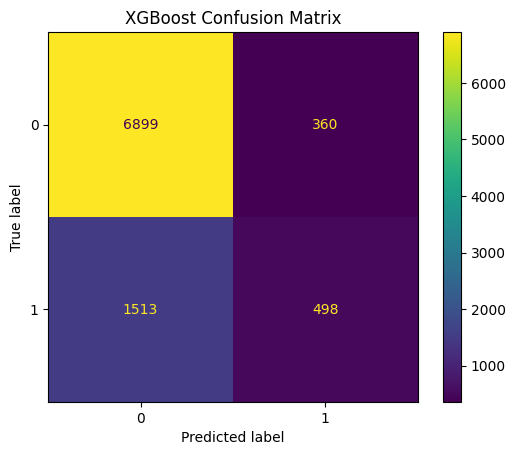

XGBoost Log Loss: 0.43812046633475776


In [48]:
# Gradient Boosting (XGBoost):

from xgboost import XGBClassifier

# Step 7: Train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(train_data[features], train_data[target])

# Step 8: Evaluate the XGBoost model
xgb_predictions = xgb_model.predict_proba(test_data[features])[:, 1]
xgb_roc_auc = roc_auc_score(test_data[target], xgb_predictions)
xgb_classification_rep = classification_report(test_data[target], xgb_model.predict(test_data[features]))

print(f'XGBoost AUC-ROC Score: {xgb_roc_auc}')
print('XGBoost Classification Report:')
print(xgb_classification_rep)

xgb_cm = confusion_matrix(test_data[target], xgb_model.predict(test_data[features]))
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=xgb_model.classes_)
xgb_disp.plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

xgb_logloss = log_loss(test_data[target], xgb_predictions)
print(f"XGBoost Log Loss: {xgb_logloss}")

In [ ]:
# Use the trained model to predict the probability of each WR scoring a touchdown in their upcoming game

# Example: Prepare the data for upcoming games (replace with your actual data)
upcoming_games_data = pd.DataFrame({
    'receptions': [5, 3, 7],  # Replace with actual data
    'targets': [8, 5, 9],     # Replace with actual data
    'receiving_yards': [65, 40, 100],  # Replace with actual data
    'opponent_defense_strength': [0.7, 0.5, 0.6]  # Replace with actual data
})

# Predict the probabilities of scoring a touchdown
upcoming_games_data['probability_of_td'] = model.predict_proba(upcoming_games_data)[:, 1]

# Display the predictions
print(upcoming_games_data[['receptions', 'targets', 'receiving_yards', 'opponent_defense_strength', 'probability_of_td']])


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

df = pd.read_csv('PlayerStats.csv')

df['scored_touchdown'] = df[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Select your features (example features)
features = [
    'Receptions', 'Targets', 'ReceivingYards',
    'OpponentDefenseRating', 'HomeGame', 'RestDays'
]

X = df[features]
y = df['scored_td']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Predict the probabilities on the test set
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Predict binary outcomes
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'ROC AUC Score: {roc_auc}')
print('Classification Report:')
print(classification_rep)


In [ ]:
# Assuming you have new game data for which you want to predict touchdown probabilities
new_game_data = pd.DataFrame({
    'Receptions': [5, 7],
    'Targets': [8, 10],
    'ReceivingYards': [75, 120],
    'OpponentDefenseRating': [85, 90],
    'HomeGame': [1, 0],
    'RestDays': [7, 10]
})

# Scale the new data using the same scaler
new_game_data_scaled = scaler.transform(new_game_data)

# Predict probabilities
new_game_probabilities = model.predict_proba(new_game_data_scaled)[:, 1]

# Output the probabilities
for i, prob in enumerate(new_game_probabilities):
    print(f'Game {i+1}: Probability of WR scoring a TD: {prob:.2f}')


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Load the dataset
data = pd.read_csv('PlayerStats.csv')

# Step 1: Filter for WRs and Exclude Unplayed Games
wr_data = data[data['position'] == 'WR']

# Separate played and unplayed games
played_games = wr_data[wr_data['season'] < 2024]
unplayed_games = wr_data[wr_data['season'] == 2024]

# Step 2: Calculate Rolling Averages
played_games = played_games.sort_values(by=['player_display_name', 'game_id'])

# Calculate rolling averages over the last 3 games for relevant stats
played_games['avg_receptions'] = played_games.groupby('player_display_name')['receptions'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
played_games['avg_targets'] = played_games.groupby('player_display_name')['targets'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
played_games['avg_receiving_yards'] = played_games.groupby('player_display_name')['receiving_yards'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Step 3: Use Rolling Averages for Unplayed Games
latest_stats = played_games.groupby('player_display_name').last().reset_index()
unplayed_games = unplayed_games.merge(latest_stats[['player_display_name', 'avg_receptions', 'avg_targets', 'avg_receiving_yards']], on='player_display_name', how='left')

# Replace missing values (if any) with 0
unplayed_games.fillna(0, inplace=True)

# Step 4: Prepare Data for Model Input
# Define features to use
features = ['avg_receptions', 'avg_targets', 'avg_receiving_yards', 'opponent_defense_strength']

# Prepare the feature matrix for played games (training data)
X = played_games[features]
y = played_games['receiving_tds'] > 0  # Binary target: 1 if receiving TD, else 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the Logistic Regression Model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Step 6: Predict Probabilities for Unplayed Games
X_new = unplayed_games[features]
X_new_scaled = scaler.transform(X_new)

# Predict probabilities for the 2024 season games
unplayed_games['TD_probability'] = model.predict_proba(X_new_scaled)[:, 1]

# Output the probabilities
result = unplayed_games[['player_display_name', 'TD_probability']]

# Display the resulting DataFrame
print(result.head())

# Optional: Save the results to a CSV file
result.to_csv('WR_TD_Probabilities_2024.csv', index=False)


/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/3786293965.py:9: DtypeWarning: Columns (2,5,6,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('PlayerStats.csv')


Accuracy: 0.7850
ROC AUC Score: 0.7312
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.97      0.88      7396
        True       0.50      0.12      0.20      2027

    accuracy                           0.78      9423
   macro avg       0.65      0.55      0.54      9423
weighted avg       0.74      0.78      0.73      9423



ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by StandardScaler.

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset with specified dtypes to avoid mixed types warning
dtype_dict = {
    'game_id': 'str',
    'season': 'str',
    'week': 'str',
    'player_current_team': 'str',
    'opponent_team': 'str',
    'home_team': 'str',
    'away_team': 'str',
    'position': 'str',
    'team_avg_points_scored': 'float64',
    'opponent_avg_points_allowed': 'float64',
    'rushing_tds': 'float64',
    'receiving_tds': 'float64'
}

data = pd.read_csv('master_model.csv', dtype=dtype_dict, low_memory=False)

# Handle missing values
numeric_cols = ['team_avg_points_scored', 'opponent_avg_points_allowed', 'rushing_tds', 'receiving_tds']
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Fill missing values for non-numeric columns
non_numeric_cols = ['player_current_team', 'opponent_team', 'home_team', 'away_team', 'position']
for col in non_numeric_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['player_current_team', 'opponent_team', 'home_team', 'away_team']
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Create the target variable (assuming scoring a touchdown means rushing_tds or receiving_tds > 0)
data['scored_touchdown'] = (data['rushing_tds'] > 0) | (data['receiving_tds'] > 0)

# Define features and target
X = data[['player_current_team', 'opponent_team', 'game_id', 'season', 'week',
          'position', 'home_team', 'away_team', 'team_avg_points_scored', 'opponent_avg_points_allowed']]
y = data['scored_touchdown']

# Convert categorical data to numeric if necessary (game_id, season, week, position)
# Here we assume they are categorical for encoding
X['game_id'] = label_encoder.fit_transform(X['game_id'])
X['season'] = label_encoder.fit_transform(X['season'])
X['week'] = label_encoder.fit_transform(X['week'])
X['position'] = label_encoder.fit_transform(X['position'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/2867478239.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['game_id'] = label_encoder.fit_transform(X['game_id'])
/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/2867478239.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['season'] = label_encoder.fit_transform(X['season'])
/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/2867478239.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.89      0.84     19395
        True       0.82      0.70      0.76     14366

    accuracy                           0.81     33761
   macro avg       0.81      0.79      0.80     33761
weighted avg       0.81      0.81      0.80     33761



In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Load the trained model and scaler
import joblib

# Load the dataset
data = pd.read_csv('master_model.csv')

# Separate the 2024 games from the rest
data_2024 = data[data['season'] == '2024']

# Prepare the 2024 data for prediction
X_2024 = data_2024[['player_current_team', 'opponent_team', 'game_id', 'season', 'week',
                    'position', 'home_team', 'away_team', 'team_avg_points_scored', 'opponent_avg_points_allowed']]

# Encode categorical variables for 2024 data
label_encoder = LabelEncoder()
categorical_cols = ['player_current_team', 'opponent_team', 'home_team', 'away_team', 'game_id', 'season', 'week', 'position']
for col in categorical_cols:
    X_2024[col] = label_encoder.fit_transform(X_2024[col])

# Load the trained scaler and model
scaler = joblib.load('scaler.pkl')
model = joblib.load('logistic_model.pkl')

# Standardize the 2024 features
X_2024_scaled = scaler.transform(X_2024)

# Make predictions for the 2024 data
probabilities = model.predict_proba(X_2024_scaled)[:, 1]  # Probabilities for class 1 (scoring a touchdown)

# Add predictions to the DataFrame
data_2024['scoring_probability'] = probabilities

# Save or display the predictions
data_2024.to_csv('predictions_2024.csv', index=False)
print(data_2024[['game_id', 'player_current_team', 'opponent_team', 'scoring_probability']])

/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/3755259721.py:9: DtypeWarning: Columns (3,6,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('master_model.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'scaler.pkl'

In [ ]:
data = pd.read_csv('master_model.csv')

# Define the features and target variable
features = [
    'opponent_avg_points_allowed',
    'opponent_avg_receiving_touchdowns_allowed',
    'opponent_avg_rushing_touchdowns_allowed',
    'opponent_avg_receiving_rushing_yards_allowed',
    'player_avg_touchdowns_scored_per_game',
    'players_team_avg_points_scored_per_game',
    'league_wr_avg_touchdowns_scored_per_game'
]

X = data[features]  # Features for the model
y = data['scored_touchdown']  # Target variable (1 if touchdown, 0 if not)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, model.predict(X_test)))
print('AUC-ROC:', roc_auc_score(y_test, y_pred_proba))

# Example: Predict probability for new data
new_data = pd.DataFrame({
    'opponent_avg_points_allowed': [24],
    'opponent_avg_receiving_touchdowns_allowed': [1.5],
    'opponent_avg_rushing_touchdowns_allowed': [1.2],
    'opponent_avg_receiving_rushing_yards_allowed': [350],
    'player_avg_touchdowns_scored_per_game': [0.7],
    'players_team_avg_points_scored_per_game': [28],
    'league_wr_avg_touchdowns_scored_per_game': [0.6]
})

# Predict the probability of scoring a touchdown
predicted_prob = model.predict_proba(new_data)[:, 1]
print("Predicted Probability of Scoring a Touchdown:", predicted_prob[0])

In [ ]:
# Use logistic regression to model the probability of a WR scoring a touchdown

data = pd.read_csv('wr_data.csv')  # Load your WR dataset

# Features and target
X = data[['targets', 'receptions', 'yards', 'yac', 'opponent_defense', 'game_location']]
y = data['scored_touchdown']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of scoring a touchdown

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')

In [ ]:
# Use your trained logistic regression model to predict the probability of wide receivers (WRs) 
# scoring a touchdown in upcoming games

upcoming_games_data = pd.DataFrame({
    'targets': [8, 5, 12],                # Number of targets
    'receptions': [6, 3, 9],              # Number of receptions
    'yards': [85, 42, 120],               # Total receiving yards
    'yac': [30, 15, 50],                  # Yards after catch
    'opponent_defense': [20, 30, 15],     # Opponent's defensive rank against WRs
    'game_location': [0, 1, 0]            # 0 for home, 1 for away
})

# Make predictions (probability of scoring a touchdown)
# The predict_proba method returns probabilities for both classes (0 and 1)
# We're interested in the probability of class 1 (scoring a touchdown)
probabilities = model.predict_proba(upcoming_games_data)[:, 1]

# Create a DataFrame to display WRs with their predicted probabilities
# Hypothetical WR names corresponding to the data
wr_names = ['WR1', 'WR2', 'WR3']
predictions = pd.DataFrame({
    'WR': wr_names,
    'Probability_of_TD': probabilities
})

# Print the predictions
print(predictions)

In [25]:
import pandas as pd

# Load the datasets
player_stats_path = 'PlayerStats.csv'
games_path = 'Games.csv'

player_stats = pd.read_csv(player_stats_path)
games = pd.read_csv(games_path)

# Display the first few rows of both datasets
print("Player Stats Data:")
print(player_stats.head())
print("\nGames Data:")
print(games.head())

# Filter the data for the 2024 season and Week 1 games
games_2024 = games[(games['season'] == 2024) & (games['week'] == 1)]

# Merge with player stats for relevant games
merged_data = pd.merge(player_stats, games_2024, on='game_id')

# Filter to only include WRs (assuming the position column holds this info)
wr_data = merged_data[merged_data['position'] == 'WR']

# Select features for the model (you can customize this based on relevance)
features = ['receptions', 'targets', 'receiving_yards', 'opponent_defense_strength']
X = wr_data[features]

# Target variable is whether a WR scored a TD in past games
y = wr_data['receiving_tds'] > 0  # Convert to binary outcome (0 or 1)

# Split the data into training (historical) and prediction (future games)
X_train = X[wr_data['season'] < 2024]
y_train = y[wr_data['season'] < 2024]

X_pred = X[wr_data['season'] == 2024]

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the probability of scoring a touchdown in Week 1 of 2024
probabilities = model.predict_proba(X_pred)[:, 1]

# Add predictions to the data for display
wr_data['touchdown_prob'] = probabilities

# Show the players with their respective probabilities for Week 1, 2024
print(wr_data[['player_display_name', 'touchdown_prob']])

Player Stats Data:
     player_display_name player_current_team         game_id  season  week  \
0  Abdul-Karim al-Jabbar                 IND  2000_01_IND_KC  2000.0     1   
1         Rabih Abdullah                  TB   2000_01_TB_NE  2000.0     1   
2         Rabih Abdullah                  TB  2000_12_TB_CHI  2000.0    12   
3         Rabih Abdullah                  TB  2000_14_DAL_TB  2000.0    14   
4         Rabih Abdullah                  TB  2000_15_TB_MIA  2000.0    15   

  position headshot_url  completions  attempts  passing_yards  ...  \
0       RB          NaN          0.0       0.0            0.0  ...   
1       RB          NaN          0.0       0.0            0.0  ...   
2       RB          NaN          0.0       0.0            0.0  ...   
3       RB          NaN          0.0       0.0            0.0  ...   
4       RB          NaN          0.0       0.0            0.0  ...   

   receptions  targets  receiving_yards  receiving_tds  receiving_fumbles  \
0         0.0 

/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/462446597.py:7: DtypeWarning: Columns (2,5,6,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  player_stats = pd.read_csv(player_stats_path)


KeyError: 'season'

In [28]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Load the datasets
player_stats_path = 'PlayerStats.csv'
games_path = 'Games.csv'

player_stats = pd.read_csv(player_stats_path)
games = pd.read_csv(games_path)

# Filter the data for the 2024 season and Week 1 games
games_2024 = games[(games['season'] == 2024) & (games['week'] == 1)]

# Merge with player stats for relevant games
merged_data = pd.merge(player_stats, games, on='game_id')

# Filter to only include WRs (assuming the position column holds this info)
wr_data = merged_data[merged_data['position'] == 'WR']

# Select features for the model (you can customize this based on relevance)
features = ['receptions', 'targets', 'receiving_yards', 'opponent_defense_strength']
X = wr_data[features]

# Target variable is whether a WR scored a TD in past games
y = wr_data['receiving_tds'] > 0  # Convert to binary outcome (0 or 1)

# Split the data into training (historical) and prediction (future games)
X_train = X[wr_data['season_x'] < 2024]
y_train = y[wr_data['season_x'] < 2024]

X_pred = X[wr_data['season_x'] == 2024]

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the probability of scoring a touchdown in Week 1 of 2024
probabilities = model.predict_proba(X_pred)[:, 1]

# Add predictions to the data for display
wr_data.loc[wr_data['season_x'] == 2024, 'touchdown_prob'] = probabilities

# Show the players with their respective probabilities for Week 1, 2024
print(wr_data[['player_display_name', 'touchdown_prob']])


/var/folders/hd/r4k9j4m15vd1bc_tnk5pn5_c0000gn/T/ipykernel_4127/688095270.py:8: DtypeWarning: Columns (2,5,6,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  player_stats = pd.read_csv(player_stats_path)


ValueError: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by LogisticRegression.

In [10]:
# # Example code

# # Load your dataset
# data = pd.read_csv('PlayerStats.csv')

# data['touchdown_scored'] = data[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# # Split the data
# msk = np.random.rand(len(data)) < 0.8
# train_df = data[msk]
# test_df = data[~msk]

# X_train = train_df[['targets', 'receptions', 'receiving_yards']]
# y_train = train_df['touchdown_scored']
# X_test = test_df[['targets', 'receptions', 'receiving_yards']]
# y_test = test_df['touchdown_scored']

# # Train the model
# clf = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.0, fit_intercept=True,
#                          intercept_scaling=1, class_weight='balanced', random_state=None,
#                          solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)
# clf.fit(X_train, y_train)

# # Predict probabilities
# y_pred = clf.predict_proba(X_test)
# y_pred = y_pred[:, 1]

# # Display results
# def display(y_pred, X_test):
#     for g in range(len(y_pred)):
#         prob = round(y_pred[g], 2)
#         player_name = X_test.reset_index().drop(columns='index').loc[g, 'player_display_name']
#         print(f'The WR {player_name} has a probability of {prob} of scoring a touchdown.')

# display(y_pred, test_df)


/Users/tylerdurette/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


The WR Troy Aikman has a probability of 0.33 of scoring a touchdown.
The WR Troy Aikman has a probability of 0.33 of scoring a touchdown.
The WR Derrick Alexander has a probability of 0.56 of scoring a touchdown.
The WR Derrick Alexander has a probability of 0.49 of scoring a touchdown.
The WR Derrick Alexander has a probability of 0.72 of scoring a touchdown.
The WR Stephen Alexander has a probability of 0.6 of scoring a touchdown.
The WR Stephen Alexander has a probability of 0.45 of scoring a touchdown.
The WR James Allen has a probability of 0.44 of scoring a touchdown.
The WR Terry Allen has a probability of 0.33 of scoring a touchdown.
The WR John Allred has a probability of 0.43 of scoring a touchdown.
The WR Mike Alstott has a probability of 0.46 of scoring a touchdown.
The WR Mike Alstott has a probability of 0.38 of scoring a touchdown.
The WR Mike Alstott has a probability of 0.33 of scoring a touchdown.
The WR Mike Alstott has a probability of 0.44 of scoring a touchdown.
T

KeyboardInterrupt: 